# NLP on two companies from twitter posts.
#### This project is an approach to apply Natural Language Processing on twitter posts to get insight of the topics that interest the most people, public opinion and sentiment analysis about two different companies in the same sector. "Electric Vehicles"

### Importing Libraries.

In [642]:
# Pandas: This library will used to create and work with dataframes.
import pandas as pd 
# Matplotlib: Used to plot graphics. 
import matplotlib.pyplot as plt
# Seaborn: Used to better style and improve graphics. 
import seaborn as sns
# Numpy for mathematic calculations. 
import numpy as np
#Tweepy: Used to work with the Twitter API.
import tweepy as tw
#ConfigParser: Used to get credentials for the twitter API.
import configparser as cp
#NLTK its used to pre-proccess text and regex its used to filter that text.
import nltk, re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
custom_stopwords_tesla = ["Tesla", "tesla", "TSLA", "tsla"]
custom_stopwords_rivian = ["Rivian", "rivian", "RIVN", "rivn"]
normalizer = WordNetLemmatizer()
#Library to count words
from collections import Counter
# library to build wordclouds
from wordcloud import WordCloud
# NLTK to analice sentiment. 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
#Another Library to perform sentiment analisis.
from textblob import Word, TextBlob
# Library to build network graph.
from pyvis.network import Network
net = Network(notebook=True)
# NLTK library to build ngrams.
from nltk.util import ngrams
# 
import networkx as nx



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Importing and authenticating API credentials from the config file. 

In [643]:
config =  cp.ConfigParser()
config.read("config.ini")

api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

# Authentication

auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

### Funtions to work with in this project.

In [644]:
# Function to perform data extraction from twitter.
def scrape(words, numtweet):
# We are using .Cursor() to search
# through twitter for the required tweets.
# The number of tweets can be
# restricted using .items(number of tweets)
    tweets = tw.Cursor(api.search_tweets,
                               words, 
                               lang="en",
                               tweet_mode='extended').items(numtweet)


# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes
# that you can access to
# get information about each tweet
    list_tweets = [tweet for tweet in tweets]
 
# we will iterate over each tweet in the
# list for extracting information about each tweet
    columns=['tweet_date','tweets']
    data = []
    for tweet in list_tweets:
        tweet_date = tweet.created_at
# Retweets can be distinguished by
# a retweeted_status attribute,
# in case it is an invalid reference,
# except block will be executed
        try:
            tweets = tweet.retweeted_status.full_text
        except AttributeError:
            tweets = tweet.full_text
            data.append([tweet_date, tweets])
# Creating DataFrame using pandas
    df = pd.DataFrame(data, columns=columns)
    return df 

#Functions to preproccess text.
def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

def preprocess_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  tokenized = word_tokenize(cleaned)
  normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if token not in stop_words]
  normalized = [token for token in normalized if token not in custom_stopword]
  return normalized

# Cleaning text. 
def clean_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  cleaned = " ".join(word for word in cleaned.split() if word not in stop_words)
  cleaned = " ".join(word for word in cleaned.split() if word not in custom_stopwords)
  cleaned = " ".join(normalizer.lemmatize(word, get_part_of_speech(word)) for word in cleaned.split())
  return cleaned

# Function to build and plot a WordCloud.
def wordcloud(str1, str2):
    wordcloud1 = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(str1))
    wordcloud2 = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(str2))
#plot the wordcloud object
    plt.figure(figsize = (15,10))
    plt.subplot(1,2,1)
    plt.title("Ford WordCloud")
    plt.imshow(wordcloud1, interpolation='bilInear')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Tesla WordCloud")
    plt.imshow(wordcloud2, interpolation='bilInear')
    plt.axis('off')
    plt.show()

#Sentiment finder
def sentiment(text):
    score = sia.polarity_scores(text)
    pos = score["pos"]
    neg = score["neg"]
    if pos > neg:
        sentiment = "positive"
    elif neg > pos:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment


### Getting the data from twitter.

In [645]:
tesla = scrape("TSLA", 100)
rivian = scrape("RIVN", 100)

### Preproccessing the data for further analisys.

In [646]:
tesla_preprocess = preprocess_text("".join(tesla.tweets), custom_stopwords_tesla)
rivian_preprocess = preprocess_text("".join(rivian.tweets), custom_stopwords_rivian)

### Counting words with bag of words

In [647]:
tesla_bow = Counter(tesla_preprocess)
rivian_bow = Counter(rivian_preprocess)

print("\nThen most frequent words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla = tesla_bow.most_common(10)
print(most_common_tesla)
print("\nTen most frequent words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian = rivian_bow.most_common(10)
print(most_common_rivian)


Then most frequent words and number of occurrences for Tesla according to Bag-of-Words:
[('1', 11), ('mention', 9), ('stock', 8), ('spy', 8), ('day', 7), ('go', 6), ('market', 6), ('price', 6), ('amc', 6), ('4', 5)]

Ten most frequent words and number of occurrences for Rivian according to Bag-of-Words:
[('stock', 19), ('2', 15), ('lcid', 14), ('know', 13), ('5', 12), ('make', 11), ('gme', 11), ('mistake', 10), ('wimi', 10), ('market', 10)]


### Building a WordCloud

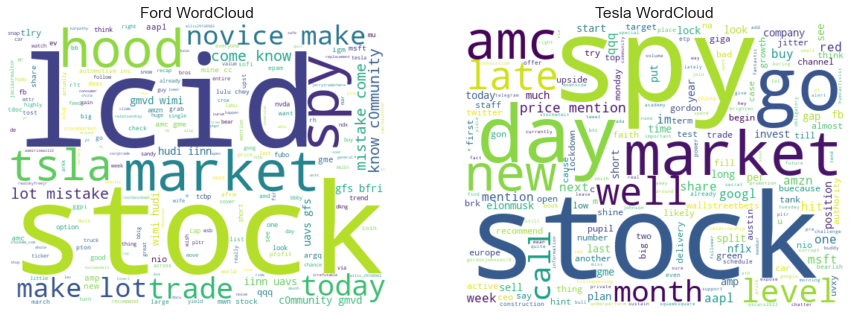

In [648]:
wordcloud(rivian_preprocess, tesla_preprocess)

### Finding the sentiment of each tweet using nltk SentimentIntensityAnalyzer

In [649]:
# In this case we just need to clean the data and create a new column with it.
tesla["clean_tweet"] = tesla["tweets"].apply(lambda x: clean_text(x, custom_stopwords_tesla))
rivian["clean_tweet"] = rivian["tweets"].apply(lambda x: clean_text(x, custom_stopwords_rivian))
# Now we can apply the sentiment function and create a new column with it.
tesla["sentiment"] = tesla["clean_tweet"].apply(sentiment)
rivian["sentiment"] = rivian["clean_tweet"].apply(sentiment)
rivian.head()


,tweet_date,tweets,clean_tweet,sentiment
0,2022-03-30 08:51:07+00:00,~When I was novice I made a lot of mistakes th...,novice make lot mistake come know c0mmunity gm...,negative
1,2022-03-30 08:20:03+00:00,these are the trending stocks $HOOD $MU $LUL...,trend stock hood mu lulu chwy mvis rh,neutral
2,2022-03-30 08:17:26+00:00,#NIO $NIO\nIt has a lower market capitalizatio...,nio nio lower market capitalization lcid big m...,negative
3,2022-03-30 07:45:51+00:00,~When I was novice I made a lot of mistakes th...,novice make lot mistake come know c0mmunity gm...,negative
4,2022-03-30 07:02:17+00:00,Most mentioned tickers in #WSB in last 1H\n\n1...,mention ticker wsb last 1h 1 gme 8 2 spy 6 3 w...,positive


### Sentiment count per company.

In [650]:
# Total sentiment count
sentiment_count_tesla =  tesla.groupby('sentiment')['sentiment'].count()
sentiment_count_rivian = rivian.groupby('sentiment')['sentiment'].count()
#Creating a df with that count to plot later. 
total_sentiments_tesla = sentiment_count_tesla.to_frame()
total_sentiments_tesla.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_tesla.reset_index(inplace=True)

total_sentiments_rivian = sentiment_count_rivian.to_frame()
total_sentiments_rivian.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_rivian.reset_index(inplace=True)

print("Total sentiment count of Ford:")
print(total_sentiments_rivian)
print("\nTotal sentiment count of Tesla: ")
print(total_sentiments_tesla)

# Sentiment count by day
day_tesla_sentiment_count = tesla.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
day_rivian_sentiment_count = rivian.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
#day_tesla_sentiment_count

Total sentiment count of Ford:
  sentiment  count
0  negative     15
1   neutral     18
2  positive     28

Total sentiment count of Tesla: 
  sentiment  count
0  negative      9
1   neutral     16
2  positive     25


### Sentiments BarCharts

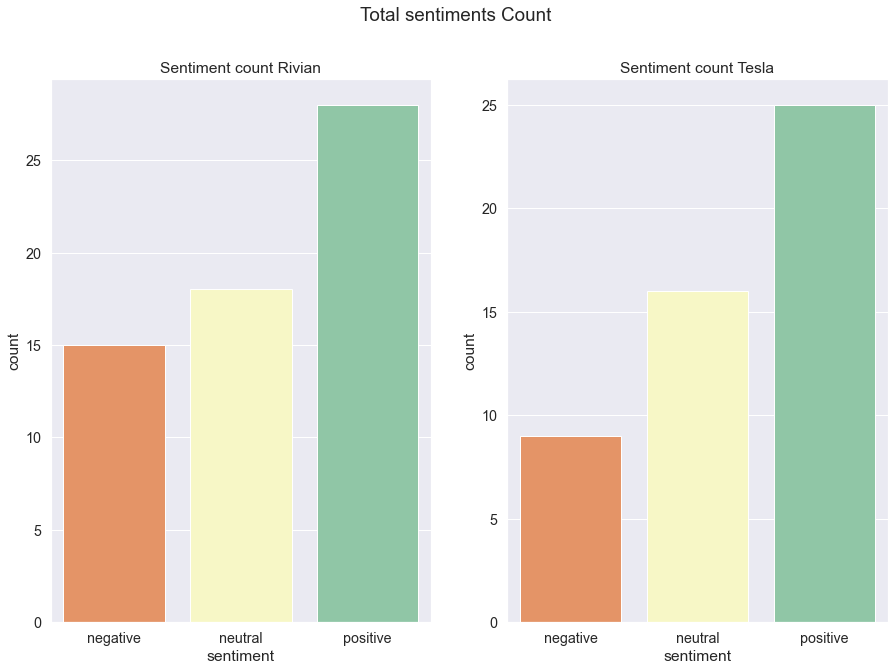

In [651]:
plt.figure(figsize=(15,10))
plt.suptitle("Total sentiments Count")
plt.subplot(1,2,1)
plt.title("Sentiment count Rivian")
sns.barplot(x="sentiment", y="count", data=total_sentiments_rivian, palette="Spectral")
plt.subplot(1,2,2)
plt.title("Sentiment count Tesla")
sns.barplot(x="sentiment", y="count", data=total_sentiments_tesla, palette="Spectral")
plt.show()

### Finding the sentiment of each tweet using TextBlob
##### Polarity: range from -1 to 1, being -1 the most negative sentiment and 1 the most positive.
##### Subjectivity: quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [652]:
tesla["polarity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
tesla["subjectivity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
rivian["polarity"] = rivian["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
rivian["subjectivity"] = rivian["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
tesla.head()

,tweet_date,tweets,clean_tweet,sentiment,polarity,subjectivity
0,2022-03-30 08:58:30+00:00,$TSLA $GOOGL Think I'll be adding to both of t...,googl think add position today mean google two...,neutral,-0.312500,0.687500
1,2022-03-30 08:57:35+00:00,@elonmusk - Any hint on how $TSLA stock will s...,elonmusk hint stock split 4 1 5 1 10 1 20 1,neutral,0.000000,0.000000
2,2022-03-30 08:55:30+00:00,"@hikingskiing 99% sure for #tsla, #btc, #pltr....",hikingskiing 99 sure btc pltr 95 eth ada,positive,0.500000,0.888889
3,2022-03-30 08:53:57+00:00,$TSLA seeing sustained chatter on wallstreetbe...,see sustain chatter wallstreetbets last day vi...,neutral,0.000000,0.066667
4,2022-03-30 08:52:16+00:00,Waiting for the obligatory “not seeing any new...,wait obligatory see news tank low volume pre m...,negative,-0.083333,0.220833


### Mean and Median of Polarity and subjectivity by brand.

In [653]:
print("Tesla")
display(tesla[["polarity", "subjectivity"]].agg([np.mean, np.median]))
print("Rivian")
rivian[["polarity", "subjectivity"]].agg([np.mean, np.median])

Tesla


,polarity,subjectivity
mean,0.035513,0.342732
median,0.000000,0.285417


Rivian


,polarity,subjectivity
mean,0.104831,0.246573
median,0.000000,0.100000


### Visualizing the moving average of the sentiments.

In [654]:
# Building dataframes for the visualization. 
tesla_ma = tesla[["tweet_date", "polarity"]]
tesla_ma = tesla_ma.sort_values(by="tweet_date", ascending=True)
tesla_ma["MA Polarity"] = tesla_ma.polarity.rolling(10, min_periods=3).mean()

rivian_ma = rivian[["tweet_date", "polarity"]]
rivian_ma = rivian_ma.sort_values(by="tweet_date", ascending=True)
rivian_ma["MA Polarity"] = rivian_ma.polarity.rolling(10, min_periods=3).mean()


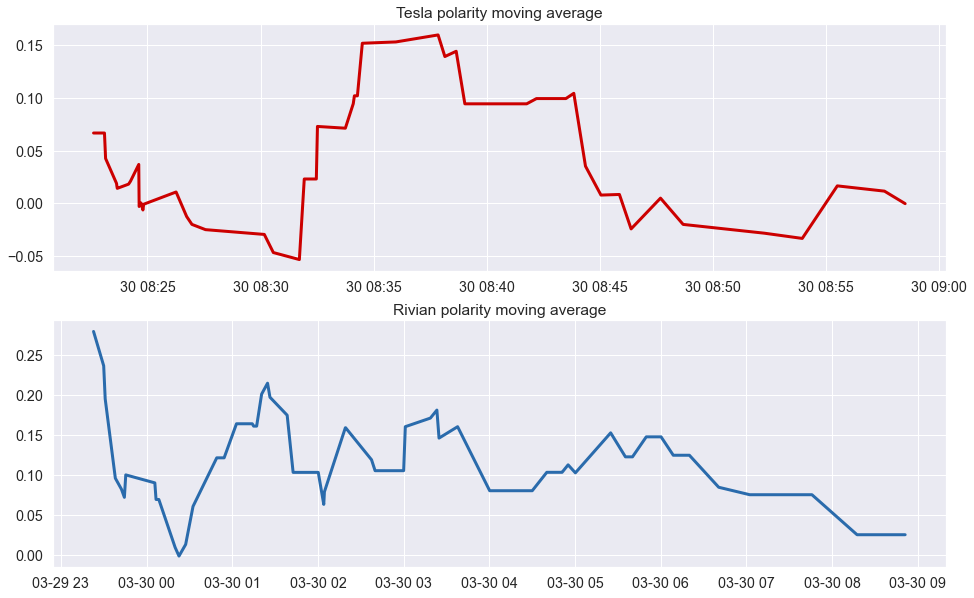

In [655]:
#Plotting both graph with matplotib. 

fig, ax = plt.subplots(2, 1, figsize=(16,10))
ax[0].plot(tesla_ma["tweet_date"], tesla_ma["MA Polarity"], color="#cc0000")
ax[0].set_title("Tesla polarity moving average")

ax[1].plot(rivian_ma["tweet_date"], rivian_ma["MA Polarity"], color="#2A6BAC")
ax[1].set_title("Rivian polarity moving average")

plt.show()

### Visualizing Subjectivity and Polarity 

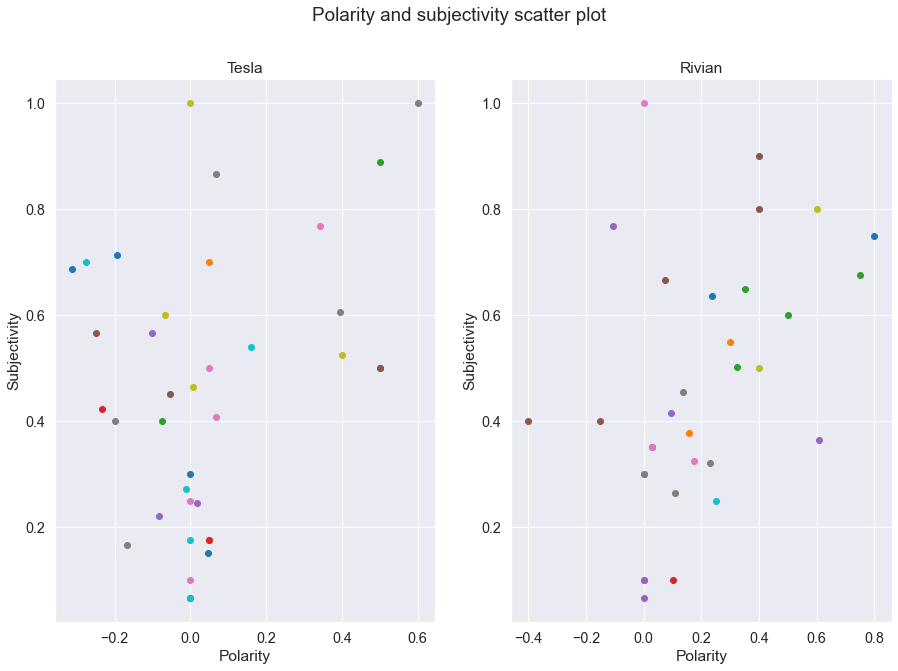

In [656]:
#Plotting both graph. 

plt.figure(figsize=(15,10))
plt.suptitle("Polarity and subjectivity scatter plot")
plt.subplot(1,2,1)
plt.title("Tesla")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(tesla)):
    plt.scatter(x=tesla["polarity"][i], y=tesla["subjectivity"][i])
plt.subplot(1,2,2)
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(rivian)):
    plt.scatter(x=rivian["polarity"][i], y=rivian["subjectivity"][i])
plt.title("Rivian")
plt.show()

### Counting the most used words by sentiment. 

In [657]:
# Joining and preprocessing all tweets based on sentiment.
tesla_preprocess_positive = preprocess_text("".join(tesla["tweets"][tesla["sentiment"] == "positive"]), custom_stopwords_tesla)
tesla_preprocess_negative = preprocess_text("".join(tesla["tweets"][tesla["sentiment"] == "negative"]), custom_stopwords_tesla)

rivian_preprocess_positive = preprocess_text("".join(rivian["tweets"][rivian["sentiment"] == "positive"]), custom_stopwords_rivian)
rivian_preprocess_negative = preprocess_text("".join(rivian["tweets"][rivian["sentiment"] == "negative"]), custom_stopwords_rivian)

#Counting the words of each sentiment. 
tesla_bow_positive = Counter(tesla_preprocess_positive)
tesla_bow_negative = Counter(tesla_preprocess_negative)

rivian_bow_positive = Counter(rivian_preprocess_positive)
rivian_bow_negative = Counter(rivian_preprocess_negative)

# Printing the most common words by sentiment. 
print("\nThen most frequent positive words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla_positive = tesla_bow_positive.most_common(10)
print(most_common_tesla_positive)

print("\nThen most frequent negative words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla_negative = tesla_bow_negative.most_common(10)
print(most_common_tesla_negative)

print("\nTen most frequent positive words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian_positive = rivian_bow_positive.most_common(10)
print(most_common_rivian_positive)

print("\nTen most frequent negative words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian_negative = rivian_bow_negative.most_common(10)
print(most_common_rivian_negative)


Then most frequent positive words and number of occurrences for Tesla according to Bag-of-Words:
[('mention', 8), ('price', 6), ('amc', 6), ('month', 5), ('stock', 5), ('well', 4), ('level', 4), ('one', 4), ('spy', 4), ('hit', 4)]

Then most frequent negative words and number of occurrences for Tesla according to Bag-of-Words:
[('market', 3), ('go', 3), ('see', 2), ('news', 2), ('red', 2), ('day', 2), ('case', 2), ('gordon', 2), ('year', 2), ('1', 2)]

Ten most frequent positive words and number of occurrences for Rivian according to Bag-of-Words:
[('5', 12), ('2', 11), ('1', 9), ('8', 9), ('3', 9), ('trade', 8), ('gme', 7), ('9', 7), ('11', 7), ('market', 7)]

Ten most frequent negative words and number of occurrences for Rivian according to Bag-of-Words:
[('mistake', 10), ('know', 10), ('novice', 9), ('make', 9), ('lot', 9), ('come', 9), ('c0mmunity', 9), ('gmvd', 9), ('wimi', 9), ('hudi', 9)]


### 2-Grams and 3-Grams are the combinations of two or three words used on twitter.

In [658]:
# Bigram
bigrams_prepped = ngrams(tesla_preprocess, 2)
print(bigrams_prepped)
bigrams = Counter(bigrams_prepped)

print("Five most frequent word sequences and the number of occurrences according to Bigrams:")
print(bigrams.most_common(5))

bigrams_prepped = ngrams(rivian_preprocess, 2)
bigrams = Counter(bigrams_prepped)

print("Five most frequent word sequences and the number of occurrences according to Bigrams:")
print(bigrams.most_common(5))

#Threegram
threegram_prepped = ngrams(tesla_preprocess, 3)
threegrams = Counter(threegram_prepped)

print("Five most frequent word sequences and the number of occurrences according to threegrams:")
print(threegrams.most_common(5))

threegrams_prepped = ngrams(rivian_preprocess, 3)
threegrams = Counter(threegrams_prepped)

print("Five most frequent word sequences and the number of occurrences according to threegrams:")
print(threegrams.most_common(5))

Five most frequent word sequences and the number of occurrences according to Bigrams:
[(('mention', '300'), 3), (('price', '1'), 3), (('stock', 'split'), 2), (('10', '1'), 2), (('pupil', 'staff'), 2)]
Five most frequent word sequences and the number of occurrences according to Bigrams:
[(('novice', 'make'), 9), (('make', 'lot'), 9), (('lot', 'mistake'), 9), (('mistake', 'come'), 9), (('come', 'know'), 9)]
Five most frequent word sequences and the number of occurrences according to threegrams:
[(('hit', 'upside', 'target'), 2), (('upside', 'target', 'level'), 2), (('im', '4', '14'), 2), (('4', '14', '1250'), 2), (('14', '1250', 'call'), 2)]
Five most frequent word sequences and the number of occurrences according to threegrams:
[(('novice', 'make', 'lot'), 9), (('make', 'lot', 'mistake'), 9), (('lot', 'mistake', 'come'), 9), (('mistake', 'come', 'know'), 9), (('come', 'know', 'c0mmunity'), 9)]


### 2 grams based on sentiments. 

In [659]:
# Positive Bigrams
bigrams_prepped_positive_tesla = ngrams(tesla_preprocess_positive, 2)
bigrams_positive_tesla = Counter(bigrams_prepped_positive_tesla)

print("Five most frequent positive word sequences in Tesla and the number of occurrences according to Bigrams:")
print(bigrams_positive_tesla.most_common(5))

# Negative Bigrams
bigrams_prepped_negative_tesla = ngrams(tesla_preprocess_negative, 2)
bigrams_negative_tesla = Counter(bigrams_prepped_negative_tesla)

print("Five most frequent negative word sequences in Tesla and the number of occurrences according to Bigrams:")
print(bigrams_negative_tesla .most_common(5))

# Positive Bigrams
bigrams_prepped_positive_rivian = ngrams(rivian_preprocess_positive, 2)
bigrams_positive_rivian = Counter(bigrams_prepped_positive_rivian)

print("Five most frequent positive word sequences in Rivian and the number of occurrences according to Bigrams:")
print(bigrams_positive_rivian.most_common(5))

# Negative Bigrams
bigrams_prepped_negative_rivian = ngrams(rivian_preprocess_negative, 2)
bigrams_negative_rivian = Counter(bigrams_prepped_negative_rivian)

print("Five most frequent negative word sequences in Rivian and the number of occurrences according to Bigrams:")
print(bigrams_negative_rivian.most_common(5))

Five most frequent positive word sequences in Tesla and the number of occurrences according to Bigrams:
[(('mention', '300'), 3), (('price', '1'), 3), (('pupil', 'staff'), 2), (('hit', 'upside'), 2), (('upside', 'target'), 2)]
Five most frequent negative word sequences in Tesla and the number of occurrences according to Bigrams:
[(('wait', 'obligatory'), 1), (('obligatory', 'see'), 1), (('see', 'news'), 1), (('news', 'tank'), 1), (('tank', 'low'), 1)]
Five most frequent positive word sequences in Rivian and the number of occurrences according to Bigrams:
[(('amc', 'gme'), 3), (('mention', 'ticker'), 2), (('ticker', 'wsb'), 2), (('1', 'gme'), 2), (('6', '3'), 2)]
Five most frequent negative word sequences in Rivian and the number of occurrences according to Bigrams:
[(('novice', 'make'), 9), (('make', 'lot'), 9), (('lot', 'mistake'), 9), (('mistake', 'come'), 9), (('come', 'know'), 9)]


### 3 grams based on sentiments. 

In [660]:
# Positive Threegrams
threegrams_prepped_positive_tesla = ngrams(tesla_preprocess_positive, 3)
threegrams_positive_tesla = Counter(threegrams_prepped_positive_tesla)

print("Five most frequent positive word sequences in Tesla and the number of occurrences according to Threegram:")
print(threegrams_positive_tesla.most_common(5))

# Negative Threegrams
threegrams_prepped_negative_tesla = ngrams(tesla_preprocess_negative, 3)
threegrams_negative_tesla = Counter(threegrams_prepped_negative_tesla)

print("Five most frequent negative word sequences in Tesla and the number of occurrences according to Threegram:")
print(threegrams_negative_tesla .most_common(5))

# Positive Threegrams
threegrams_prepped_positive_rivian = ngrams(rivian_preprocess_positive, 3)
threegrams_positive_rivian = Counter(threegrams_prepped_positive_rivian)

print("Five most frequent positive word sequences in Rivian and the number of occurrences according to Threegram:")
print(threegrams_positive_rivian.most_common(5))

# Negative Threegrams
threegrams_prepped_negative_rivian = ngrams(rivian_preprocess_negative, 3)
threegrams_negative_rivian = Counter(threegrams_prepped_negative_rivian)

print("Five most frequent negative word sequences in Rivian and the number of occurrences according to Threegram:")
print(threegrams_negative_rivian.most_common(5))

Five most frequent positive word sequences in Tesla and the number of occurrences according to Threegram:
[(('hit', 'upside', 'target'), 2), (('upside', 'target', 'level'), 2), (('im', '4', '14'), 2), (('4', '14', '1250'), 2), (('14', '1250', 'call'), 2)]
Five most frequent negative word sequences in Tesla and the number of occurrences according to Threegram:
[(('wait', 'obligatory', 'see'), 1), (('obligatory', 'see', 'news'), 1), (('see', 'news', 'tank'), 1), (('news', 'tank', 'low'), 1), (('tank', 'low', 'volume'), 1)]
Five most frequent positive word sequences in Rivian and the number of occurrences according to Threegram:
[(('mention', 'ticker', 'wsb'), 2), (('need', 'know', 'short'), 2), (('know', 'short', 'cover'), 2), (('short', 'cover', 'single'), 2), (('cover', 'single', 'share'), 2)]
Five most frequent negative word sequences in Rivian and the number of occurrences according to Threegram:
[(('novice', 'make', 'lot'), 9), (('make', 'lot', 'mistake'), 9), (('lot', 'mistake', 'c

### Building a new dataframe for network explorations. 

In [664]:
tesla["preprocess_tweets"] = tesla["tweets"].apply(lambda x: preprocess_text(x, custom_stopwords_tesla))
tesla["bows"] = tesla["preprocess_tweets"].apply(lambda x: Counter(x))
tesla["bigrams"] = tesla["preprocess_tweets"].apply(lambda x: ngrams(x, 2))
tesla["bigrams"] = tesla["bigrams"].apply(lambda x: Counter(x))
tesla["threegrams"] = tesla["preprocess_tweets"].apply(lambda x: ngrams(x, 3))
tesla["threegrams"] = tesla["threegrams"].apply(lambda x: Counter(x))

rivian["preprocess_tweets"] = rivian["tweets"].apply(lambda x: preprocess_text(x, custom_stopwords_rivian))
rivian["bows"] = rivian["preprocess_tweets"].apply(lambda x: Counter(x))
rivian["bigrams"] = rivian["preprocess_tweets"].apply(lambda x: ngrams(x, 2))
rivian["bigrams"] = rivian["bigrams"].apply(lambda x: Counter(x))
rivian["threegrams"] = rivian["preprocess_tweets"].apply(lambda x: ngrams(x, 3))
rivian["threegrams"] = rivian["threegrams"].apply(lambda x: Counter(x))

tesla.head()

,tweet_date,tweets,clean_tweet,sentiment,polarity,subjectivity,preprocess_tweets,bows,bigrams,threegrams
0,2022-03-30 08:58:30+00:00,$TSLA $GOOGL Think I'll be adding to both of t...,googl think add position today mean google two...,neutral,-0.312500,0.687500,"[googl, think, add, position, today, mean, goo...","{'googl': 1, 'think': 1, 'add': 1, 'position':...","{('googl', 'think'): 1, ('think', 'add'): 1, (...","{('googl', 'think', 'add'): 1, ('think', 'add'..."
1,2022-03-30 08:57:35+00:00,@elonmusk - Any hint on how $TSLA stock will s...,elonmusk hint stock split 4 1 5 1 10 1 20 1,neutral,0.000000,0.000000,"[elonmusk, hint, stock, split, 4, 1, 5, 1, 10,...","{'elonmusk': 1, 'hint': 1, 'stock': 1, 'split'...","{('elonmusk', 'hint'): 1, ('hint', 'stock'): 1...","{('elonmusk', 'hint', 'stock'): 1, ('hint', 's..."
2,2022-03-30 08:55:30+00:00,"@hikingskiing 99% sure for #tsla, #btc, #pltr....",hikingskiing 99 sure btc pltr 95 eth ada,positive,0.500000,0.888889,"[hikingskiing, 99, sure, btc, pltr, 95, eth, ada]","{'hikingskiing': 1, '99': 1, 'sure': 1, 'btc':...","{('hikingskiing', '99'): 1, ('99', 'sure'): 1,...","{('hikingskiing', '99', 'sure'): 1, ('99', 'su..."
3,2022-03-30 08:53:57+00:00,$TSLA seeing sustained chatter on wallstreetbe...,see sustain chatter wallstreetbets last day vi...,neutral,0.000000,0.066667,"[see, sustain, chatter, wallstreetbets, last, ...","{'see': 1, 'sustain': 1, 'chatter': 1, 'wallst...","{('see', 'sustain'): 1, ('sustain', 'chatter')...","{('see', 'sustain', 'chatter'): 1, ('sustain',..."
4,2022-03-30 08:52:16+00:00,Waiting for the obligatory “not seeing any new...,wait obligatory see news tank low volume pre m...,negative,-0.083333,0.220833,"[wait, obligatory, see, news, tank, low, volum...","{'wait': 1, 'obligatory': 1, 'see': 1, 'news':...","{('wait', 'obligatory'): 1, ('obligatory', 'se...","{('wait', 'obligatory', 'see'): 1, ('obligator..."


In [667]:
sns.barplot(data=tesla, x="bigrams"[0], y="bigrams"[1])
plt.show()

ValueError: Could not interpret input 'b'

### Network Analysis

In [666]:

G = nx.from_pandas_edgelist(tesla, source="sentiment", target=threegrams_positive_tesla)
plt.figure(figsize=(15,10))
nt = nx.draw_networkx(G)
plt.show()

/Users/macbookair/opt/miniconda3/lib/python3.8/site-packages/networkx/convert_matrix.py:427: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  g.add_edges_from(zip(df[source], df[target]))


KeyError: "None of [Index([            ('hikingskiing', '99', 'sure'),\n                            ('99', 'sure', 'btc'),\n                          ('sure', 'btc', 'pltr'),\n                            ('btc', 'pltr', '95'),\n                            ('pltr', '95', 'eth'),\n                ('95', 'eth', 'adarelationships'),\n         ('eth', 'adarelationships', 'important'),\n       ('adarelationships', 'important', 'thing'),\n                    ('important', 'thing', 'try'),\n                          ('thing', 'try', 'get'),\n       ...\n                        ('sell', 'share', 'even'),\n                          ('share', 'even', 'mo'),\n                             ('even', 'mo', 'ed'),\n                             ('mo', 'ed', 'clvr'),\n                          ('ed', 'clvr', 'check'),\n                         ('clvr', 'check', 'low'),\n                        ('check', 'low', 'float'),\n                        ('low', 'float', 'great'),\n                     ('float', 'great', 'runner'),\n                       ('great', 'runner', 'imo')],\n      dtype='object', length=421)] are in the [columns]"